<a href="https://colab.research.google.com/github/carloscotrini/transformers_from_scratch/blob/main/AML_TinyDiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
from torch.utils.data import Dataset
from sklearn.datasets import make_swiss_roll

class SwissRoll(Dataset):

  def __init__(self, num_samples):
    super().__init__()
    self.data, _ = make_swiss_roll(n_samples=num_samples, noise=0.05)
    self.data = self.data[:, [0, 2]]
    self.data = torch.tensor(self.data, dtype=torch.float32)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [223]:
import torch.nn as nn
import torch

class MLP(nn.Module):

  def __init__(self, input_dim, hidden_dim, T):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(2 * input_dim + hidden_dim, 4 * hidden_dim),
        nn.BatchNorm1d(4 * hidden_dim),
        nn.ReLU(),
        nn.Linear(4 * hidden_dim, 2 * hidden_dim),
        nn.BatchNorm1d(2 * hidden_dim),
        nn.ReLU(),
        nn.Linear(2 * hidden_dim, input_dim)
    )
    self.time_emb = nn.Embedding(T, hidden_dim)

  def forward(self, xT, xt, t):
    t_emb = self.time_emb(t)
    t_emb = t_emb.repeat(xt.shape[0], 1)
    x = torch.cat([xT, xt, t_emb], dim=1)
    return self.layers(x)

In [224]:
import numpy as np

class DiffusionModel():
  def __init__(self, model, T, beta):
    self.model = model
    self.T = T
    self.beta = beta

  def step_forward(self, x0):
    # Sample from a Gaussian with dimensions as in x
    noise = torch.randn_like(x0)
    return (1 - self.beta) * x0 + self.beta * noise

  def forward(self, x0, t):
    # Sample from a Gaussian with dimensions as in x
    x = x0
    for i in range(t):
      x = self.step_forward(x)
    return x

  def step_reverse(self, xT, xt, t):
    return xt - self.model(xT, xt, t)

  def sample(self, num_samples, shape):
    shape = (num_samples, *shape)
    xT = torch.randn(*shape)
    t = self.T - 1
    while t > 0:
      x = self.step_reverse(xT, x, torch.tensor(t))
      t -= 1
    return x

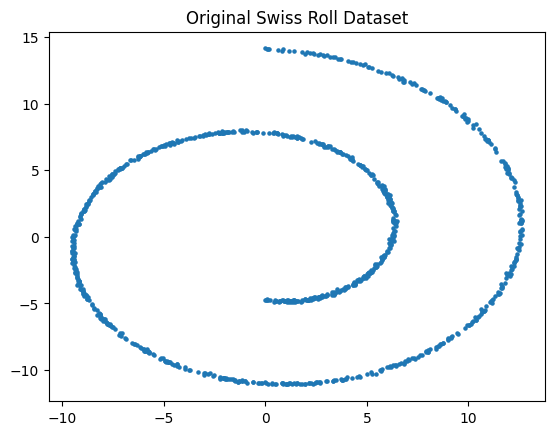

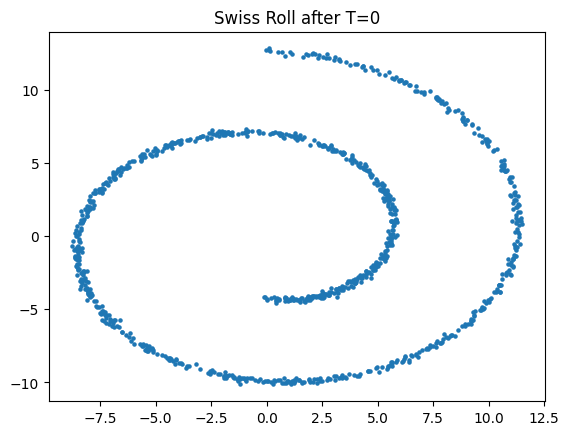

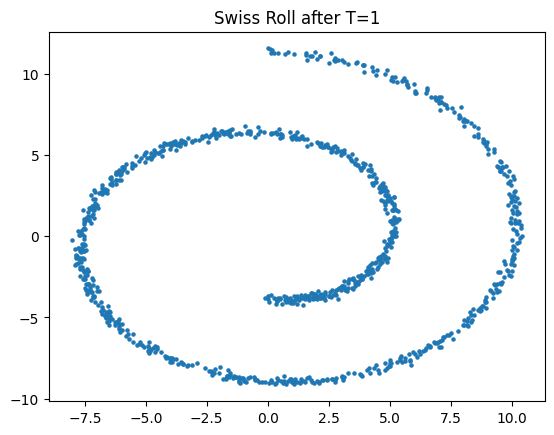

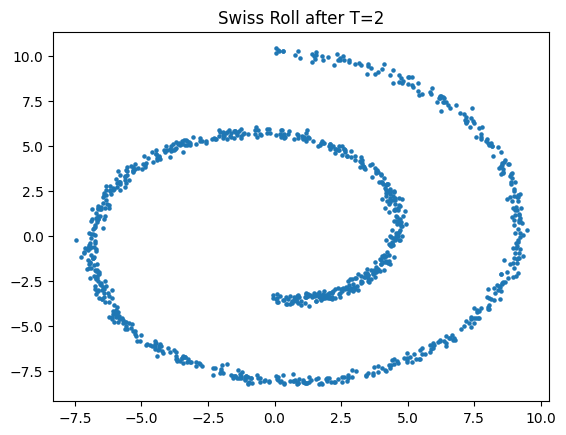

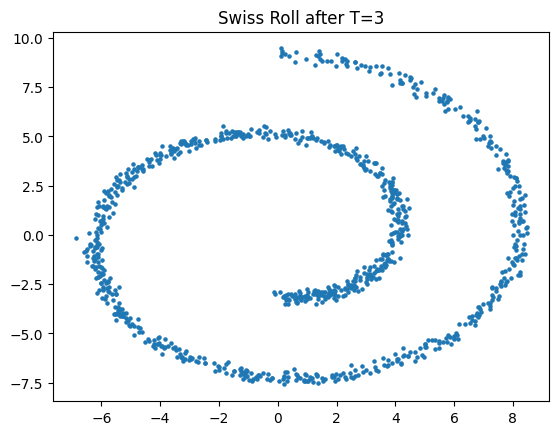

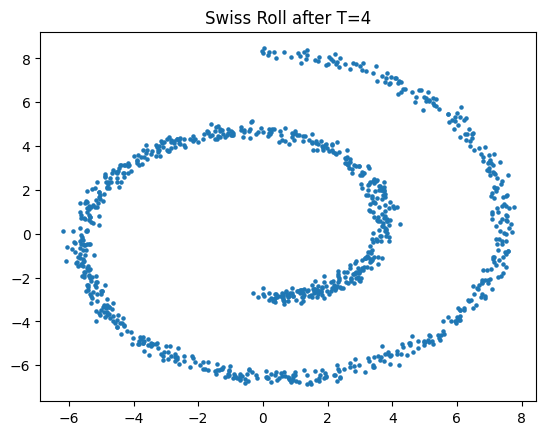

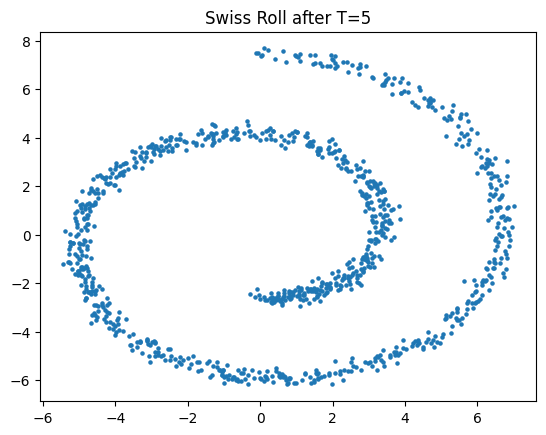

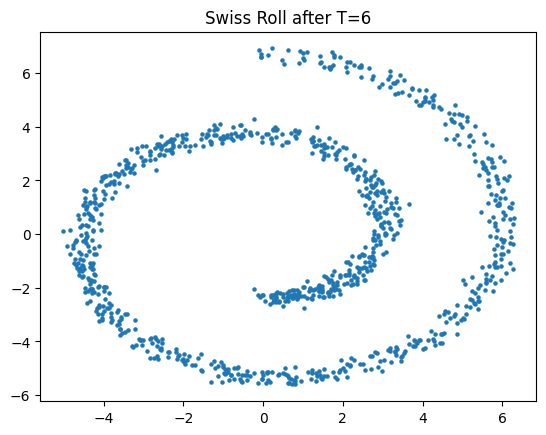

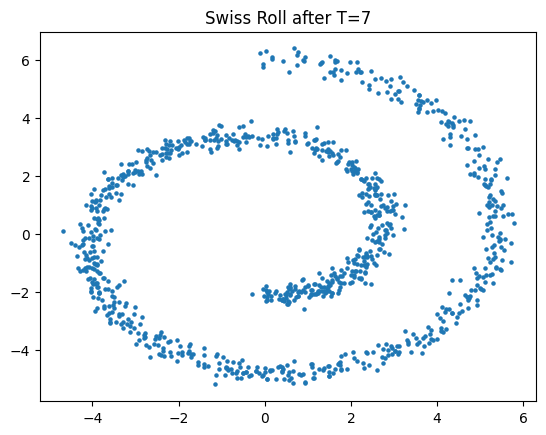

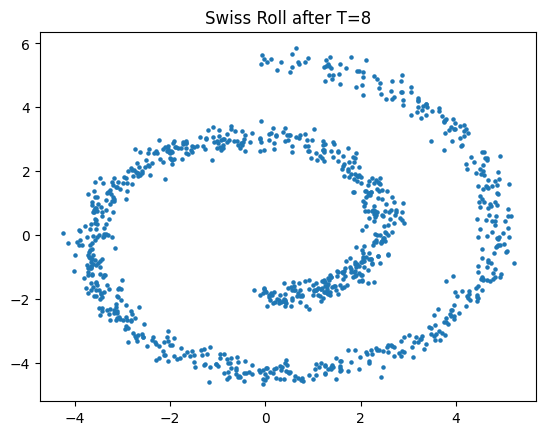

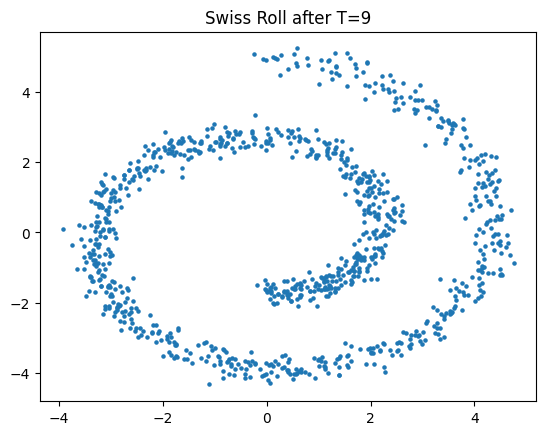

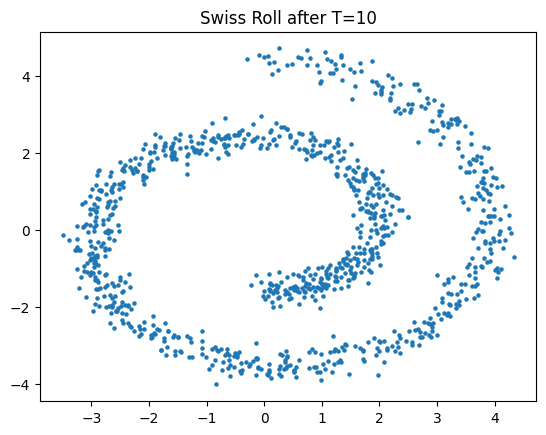

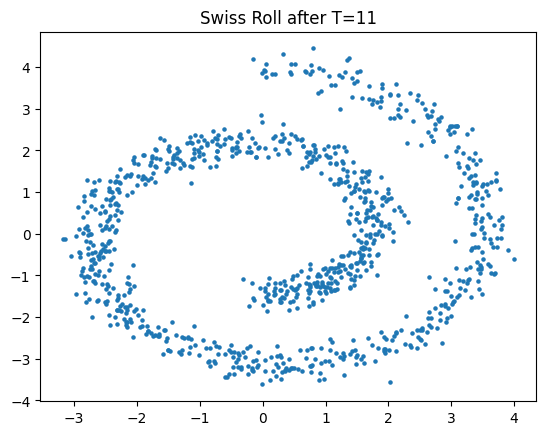

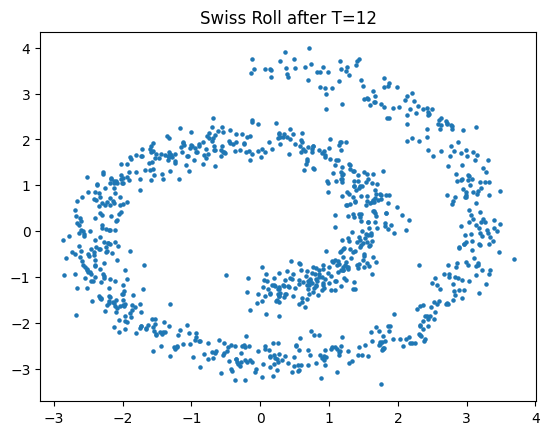

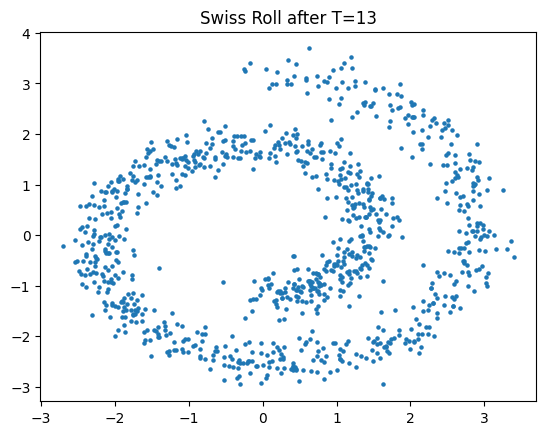

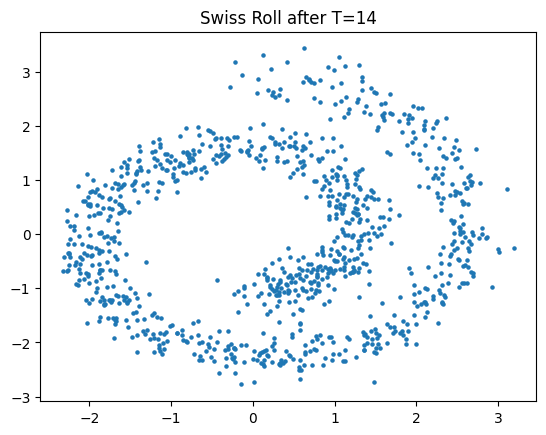

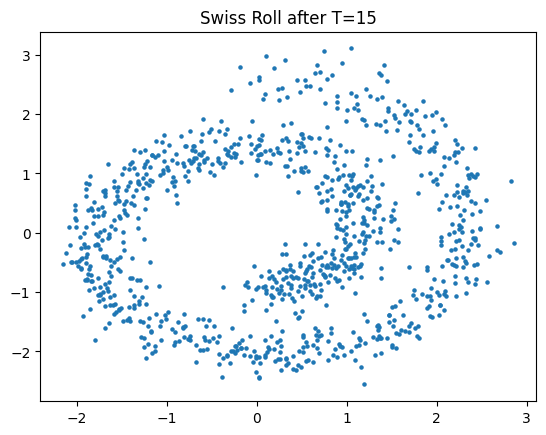

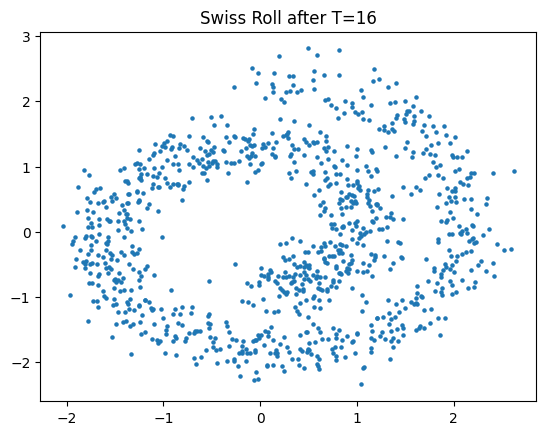

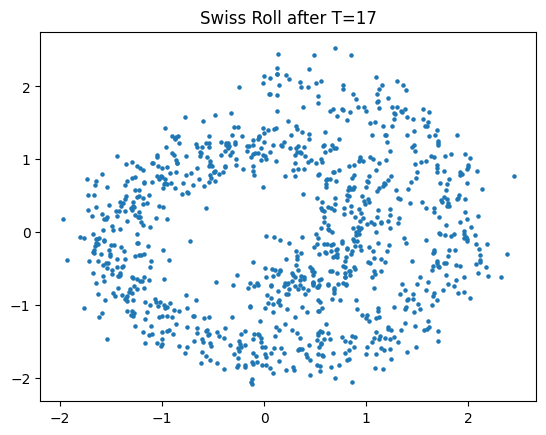

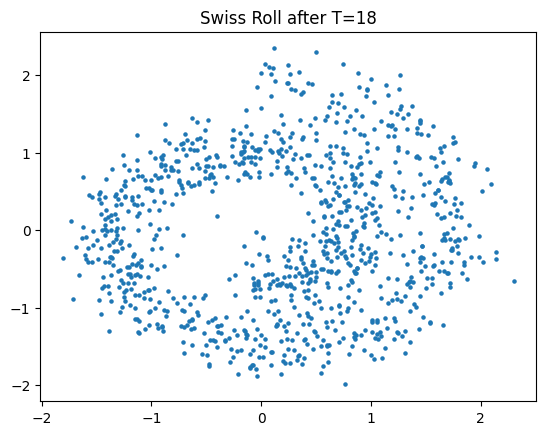

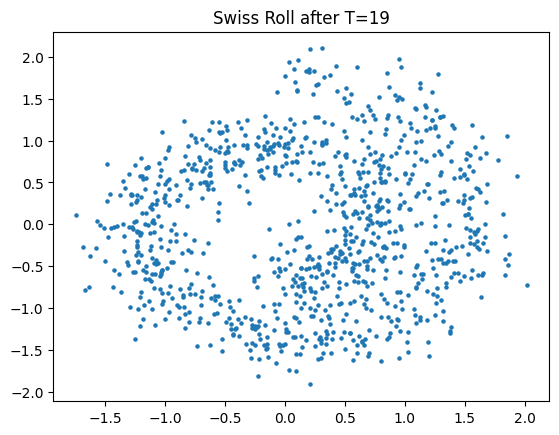

In [225]:
# prompt: Generate a dataset for the swiss roll with 1000 samples. Plot them. Then Pass them through the forward process of a diffusion model. Then plot the results after T/2 and T

import matplotlib.pyplot as plt

# Generate dataset
dataset = SwissRoll(num_samples=1000)

# Plot the original dataset
plt.figure()
plt.scatter(dataset.data[:, 0], dataset.data[:, 1], s=5)
plt.title('Original Swiss Roll Dataset')
plt.show()

# Initialize diffusion model
T = 20
model = MLP(input_dim=2, hidden_dim=64, T=T)
diffusion_model = DiffusionModel(model, T, beta=0.1)

x = dataset.data
for t in range(T):
  x = diffusion_model.step_forward(x)
  plt.figure()
  plt.scatter(x[:, 0], x[:, 1], s=5)
  plt.title(f'Swiss Roll after T={t}')
  plt.show()


In [228]:
# prompt: Train the diffusion model above using the given MLP
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50 * T
batch_size = 128

model.train()
losses = [[] for _ in range(T)]
for epoch in tqdm(range(num_epochs)):
  epoch_losses = [0 for _ in range(T)]
  for i in range(0, len(dataset), batch_size):
    x = dataset[i: i + batch_size]
    xts = [x]
    for t in range(T):
      # t = torch.randint(0, T-1, (1,), dtype=torch.long)
      xts.append(diffusion_model.step_forward(xts[-1]))

    for t in range(T-1, 0, -1):
      x_recon = xts[t] - model(xT=xts[-1], xt=xts[t], t=torch.tensor(t))
      loss = nn.functional.mse_loss(x_recon, xts[t-1])
      epoch_losses[t] += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  for t in range(T):
    losses[t].append(epoch_losses[t])


  1%|          | 10/1000 [00:05<10:24,  1.58it/s]

Epoch [10/1000], Loss: 0.0121


  2%|▏         | 20/1000 [00:11<09:01,  1.81it/s]

Epoch [20/1000], Loss: 0.0131


  3%|▎         | 30/1000 [00:17<08:49,  1.83it/s]

Epoch [30/1000], Loss: 0.0153


  4%|▍         | 40/1000 [00:24<09:49,  1.63it/s]

Epoch [40/1000], Loss: 0.0115


  5%|▌         | 50/1000 [00:29<08:52,  1.78it/s]

Epoch [50/1000], Loss: 0.0138


  6%|▌         | 60/1000 [00:36<11:14,  1.39it/s]

Epoch [60/1000], Loss: 0.0154


  7%|▋         | 70/1000 [00:42<09:13,  1.68it/s]

Epoch [70/1000], Loss: 0.0145


  8%|▊         | 80/1000 [00:49<12:04,  1.27it/s]

Epoch [80/1000], Loss: 0.0133


  9%|▉         | 90/1000 [00:55<08:30,  1.78it/s]

Epoch [90/1000], Loss: 0.0130


 10%|█         | 100/1000 [01:01<11:11,  1.34it/s]

Epoch [100/1000], Loss: 0.0111


 11%|█         | 110/1000 [01:07<08:25,  1.76it/s]

Epoch [110/1000], Loss: 0.0123


 12%|█▏        | 120/1000 [01:13<08:41,  1.69it/s]

Epoch [120/1000], Loss: 0.0106


 13%|█▎        | 130/1000 [01:20<08:35,  1.69it/s]

Epoch [130/1000], Loss: 0.0125


 14%|█▍        | 140/1000 [01:26<11:21,  1.26it/s]

Epoch [140/1000], Loss: 0.0134


 15%|█▌        | 150/1000 [01:33<08:22,  1.69it/s]

Epoch [150/1000], Loss: 0.0120


 16%|█▌        | 160/1000 [01:39<07:43,  1.81it/s]

Epoch [160/1000], Loss: 0.0124


 17%|█▋        | 170/1000 [01:45<08:52,  1.56it/s]

Epoch [170/1000], Loss: 0.0140


 18%|█▊        | 180/1000 [01:52<09:52,  1.38it/s]

Epoch [180/1000], Loss: 0.0113


 19%|█▉        | 190/1000 [01:59<08:44,  1.54it/s]

Epoch [190/1000], Loss: 0.0108


 20%|██        | 200/1000 [02:04<07:08,  1.87it/s]

Epoch [200/1000], Loss: 0.0123


 21%|██        | 210/1000 [02:11<09:59,  1.32it/s]

Epoch [210/1000], Loss: 0.0112


 22%|██▏       | 220/1000 [02:16<07:06,  1.83it/s]

Epoch [220/1000], Loss: 0.0116


 23%|██▎       | 230/1000 [02:22<08:08,  1.58it/s]

Epoch [230/1000], Loss: 0.0119


 24%|██▍       | 240/1000 [02:28<07:20,  1.72it/s]

Epoch [240/1000], Loss: 0.0121


 25%|██▌       | 250/1000 [02:34<06:54,  1.81it/s]

Epoch [250/1000], Loss: 0.0124


 26%|██▌       | 260/1000 [02:41<07:30,  1.64it/s]

Epoch [260/1000], Loss: 0.0137


 27%|██▋       | 270/1000 [02:46<06:39,  1.83it/s]

Epoch [270/1000], Loss: 0.0109


 28%|██▊       | 280/1000 [02:53<08:24,  1.43it/s]

Epoch [280/1000], Loss: 0.0122


 29%|██▉       | 290/1000 [02:59<06:48,  1.74it/s]

Epoch [290/1000], Loss: 0.0108


 30%|███       | 300/1000 [03:07<11:44,  1.01s/it]

Epoch [300/1000], Loss: 0.0111


 31%|███       | 310/1000 [03:13<06:38,  1.73it/s]

Epoch [310/1000], Loss: 0.0108


 32%|███▏      | 320/1000 [03:19<08:57,  1.27it/s]

Epoch [320/1000], Loss: 0.0128


 33%|███▎      | 330/1000 [03:25<06:43,  1.66it/s]

Epoch [330/1000], Loss: 0.0110


 34%|███▍      | 340/1000 [03:33<08:53,  1.24it/s]

Epoch [340/1000], Loss: 0.0118


 35%|███▌      | 350/1000 [03:39<06:52,  1.58it/s]

Epoch [350/1000], Loss: 0.0104


 36%|███▌      | 360/1000 [03:46<08:21,  1.28it/s]

Epoch [360/1000], Loss: 0.0114


 37%|███▋      | 370/1000 [03:53<06:31,  1.61it/s]

Epoch [370/1000], Loss: 0.0103


 38%|███▊      | 380/1000 [04:00<08:16,  1.25it/s]

Epoch [380/1000], Loss: 0.0110


 39%|███▉      | 390/1000 [04:06<06:32,  1.55it/s]

Epoch [390/1000], Loss: 0.0108


 40%|████      | 400/1000 [04:14<08:30,  1.17it/s]

Epoch [400/1000], Loss: 0.0113


 41%|████      | 410/1000 [04:20<06:15,  1.57it/s]

Epoch [410/1000], Loss: 0.0116


 42%|████▏     | 420/1000 [04:27<07:38,  1.27it/s]

Epoch [420/1000], Loss: 0.0090


 43%|████▎     | 430/1000 [04:33<05:53,  1.61it/s]

Epoch [430/1000], Loss: 0.0114


 44%|████▍     | 440/1000 [04:41<07:40,  1.22it/s]

Epoch [440/1000], Loss: 0.0082


 45%|████▌     | 450/1000 [04:48<06:08,  1.49it/s]

Epoch [450/1000], Loss: 0.0115


 46%|████▌     | 460/1000 [04:55<07:23,  1.22it/s]

Epoch [460/1000], Loss: 0.0105


 47%|████▋     | 470/1000 [05:01<05:23,  1.64it/s]

Epoch [470/1000], Loss: 0.0103


 48%|████▊     | 480/1000 [05:08<06:57,  1.25it/s]

Epoch [480/1000], Loss: 0.0116


 49%|████▉     | 490/1000 [05:14<05:14,  1.62it/s]

Epoch [490/1000], Loss: 0.0105


 50%|█████     | 500/1000 [05:21<06:40,  1.25it/s]

Epoch [500/1000], Loss: 0.0110


 51%|█████     | 510/1000 [05:28<05:04,  1.61it/s]

Epoch [510/1000], Loss: 0.0100


 52%|█████▏    | 520/1000 [05:35<06:31,  1.23it/s]

Epoch [520/1000], Loss: 0.0113


 53%|█████▎    | 530/1000 [05:41<05:05,  1.54it/s]

Epoch [530/1000], Loss: 0.0118


 54%|█████▍    | 540/1000 [05:48<06:19,  1.21it/s]

Epoch [540/1000], Loss: 0.0118


 55%|█████▌    | 550/1000 [05:55<04:38,  1.61it/s]

Epoch [550/1000], Loss: 0.0121


 56%|█████▌    | 560/1000 [06:02<05:55,  1.24it/s]

Epoch [560/1000], Loss: 0.0094


 57%|█████▋    | 570/1000 [06:08<04:35,  1.56it/s]

Epoch [570/1000], Loss: 0.0125


 58%|█████▊    | 580/1000 [06:15<05:42,  1.23it/s]

Epoch [580/1000], Loss: 0.0104


 59%|█████▉    | 590/1000 [06:22<04:19,  1.58it/s]

Epoch [590/1000], Loss: 0.0094


 60%|██████    | 600/1000 [06:29<05:15,  1.27it/s]

Epoch [600/1000], Loss: 0.0113


 61%|██████    | 610/1000 [06:35<04:02,  1.61it/s]

Epoch [610/1000], Loss: 0.0117


 62%|██████▏   | 620/1000 [06:42<05:05,  1.24it/s]

Epoch [620/1000], Loss: 0.0090


 63%|██████▎   | 630/1000 [06:49<03:52,  1.59it/s]

Epoch [630/1000], Loss: 0.0094


 64%|██████▍   | 640/1000 [06:56<04:52,  1.23it/s]

Epoch [640/1000], Loss: 0.0109


 65%|██████▌   | 650/1000 [07:03<03:44,  1.56it/s]

Epoch [650/1000], Loss: 0.0118


 66%|██████▌   | 660/1000 [07:10<04:46,  1.19it/s]

Epoch [660/1000], Loss: 0.0087


 67%|██████▋   | 670/1000 [07:17<03:29,  1.57it/s]

Epoch [670/1000], Loss: 0.0116


 68%|██████▊   | 680/1000 [07:24<04:40,  1.14it/s]

Epoch [680/1000], Loss: 0.0102


 69%|██████▉   | 690/1000 [07:31<03:32,  1.46it/s]

Epoch [690/1000], Loss: 0.0098


 70%|███████   | 700/1000 [07:39<04:12,  1.19it/s]

Epoch [700/1000], Loss: 0.0093


 71%|███████   | 710/1000 [07:45<03:06,  1.55it/s]

Epoch [710/1000], Loss: 0.0105


 72%|███████▏  | 720/1000 [07:53<03:35,  1.30it/s]

Epoch [720/1000], Loss: 0.0094


 73%|███████▎  | 730/1000 [08:00<02:58,  1.51it/s]

Epoch [730/1000], Loss: 0.0084


 74%|███████▍  | 740/1000 [08:07<03:15,  1.33it/s]

Epoch [740/1000], Loss: 0.0106


 75%|███████▌  | 750/1000 [08:14<02:47,  1.49it/s]

Epoch [750/1000], Loss: 0.0115


 76%|███████▌  | 760/1000 [08:22<02:53,  1.39it/s]

Epoch [760/1000], Loss: 0.0112


 77%|███████▋  | 770/1000 [08:29<02:34,  1.49it/s]

Epoch [770/1000], Loss: 0.0105


 78%|███████▊  | 780/1000 [08:37<02:33,  1.44it/s]

Epoch [780/1000], Loss: 0.0097


 79%|███████▉  | 790/1000 [08:43<02:19,  1.51it/s]

Epoch [790/1000], Loss: 0.0101


 80%|████████  | 800/1000 [08:51<02:16,  1.47it/s]

Epoch [800/1000], Loss: 0.0103


 81%|████████  | 810/1000 [08:58<02:24,  1.31it/s]

Epoch [810/1000], Loss: 0.0110


 82%|████████▏ | 820/1000 [09:05<02:01,  1.48it/s]

Epoch [820/1000], Loss: 0.0099


 83%|████████▎ | 830/1000 [09:12<02:22,  1.19it/s]

Epoch [830/1000], Loss: 0.0109


 84%|████████▍ | 840/1000 [09:19<01:47,  1.49it/s]

Epoch [840/1000], Loss: 0.0107


 85%|████████▌ | 850/1000 [09:27<02:11,  1.14it/s]

Epoch [850/1000], Loss: 0.0108


 86%|████████▌ | 860/1000 [09:34<01:36,  1.45it/s]

Epoch [860/1000], Loss: 0.0111


 87%|████████▋ | 870/1000 [09:42<01:43,  1.26it/s]

Epoch [870/1000], Loss: 0.0090


 88%|████████▊ | 880/1000 [09:49<01:19,  1.51it/s]

Epoch [880/1000], Loss: 0.0085


 89%|████████▉ | 890/1000 [09:56<01:20,  1.37it/s]

Epoch [890/1000], Loss: 0.0103


 90%|█████████ | 900/1000 [10:03<01:07,  1.48it/s]

Epoch [900/1000], Loss: 0.0092


 91%|█████████ | 910/1000 [10:11<01:04,  1.40it/s]

Epoch [910/1000], Loss: 0.0093


 92%|█████████▏| 920/1000 [10:18<00:54,  1.47it/s]

Epoch [920/1000], Loss: 0.0108


 93%|█████████▎| 930/1000 [10:25<00:47,  1.46it/s]

Epoch [930/1000], Loss: 0.0074


 94%|█████████▍| 940/1000 [10:32<00:46,  1.29it/s]

Epoch [940/1000], Loss: 0.0111


 95%|█████████▌| 950/1000 [10:40<00:35,  1.43it/s]

Epoch [950/1000], Loss: 0.0105


 96%|█████████▌| 960/1000 [10:48<00:35,  1.14it/s]

Epoch [960/1000], Loss: 0.0098


 97%|█████████▋| 970/1000 [10:55<00:20,  1.44it/s]

Epoch [970/1000], Loss: 0.0083


 98%|█████████▊| 980/1000 [11:03<00:16,  1.19it/s]

Epoch [980/1000], Loss: 0.0087


 99%|█████████▉| 990/1000 [11:10<00:07,  1.42it/s]

Epoch [990/1000], Loss: 0.0105


100%|██████████| 1000/1000 [11:18<00:00,  1.47it/s]

Epoch [1000/1000], Loss: 0.0105


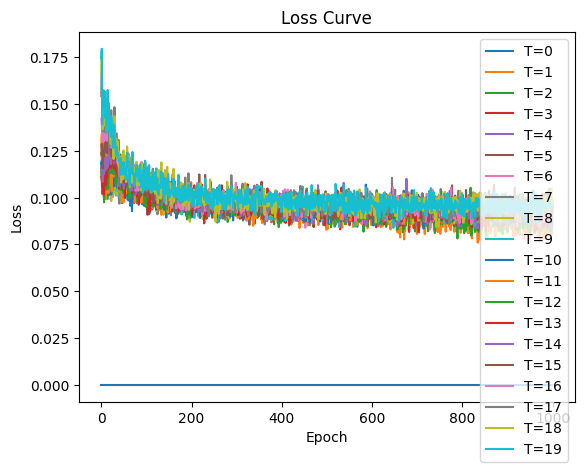

In [229]:
# Plot the loss curve
plt.figure()
for t in range(T):
  plt.plot(losses[t], label=f'T={t}')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

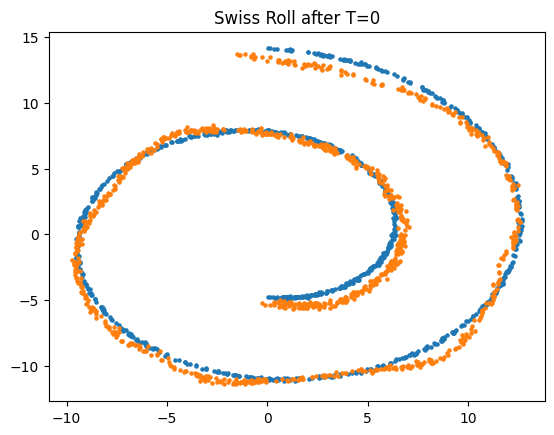

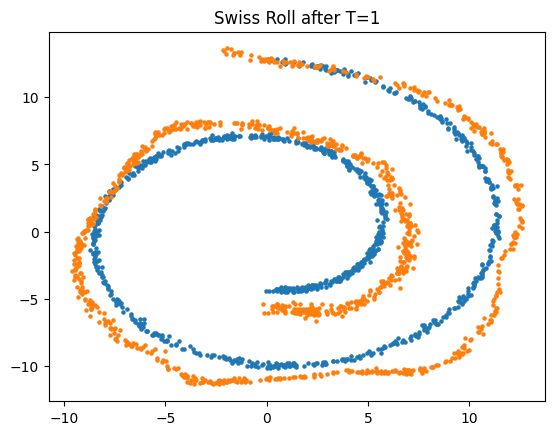

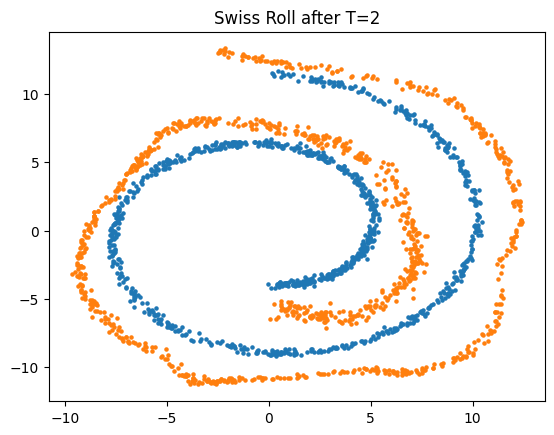

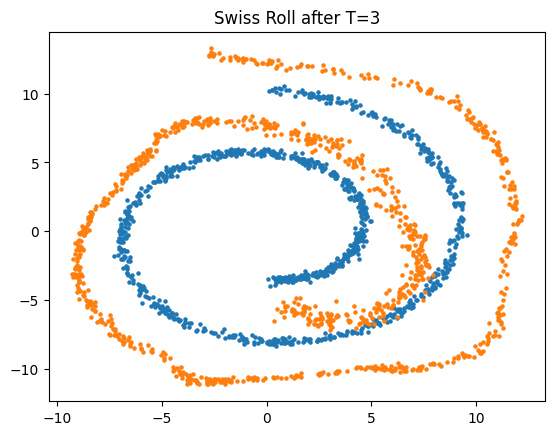

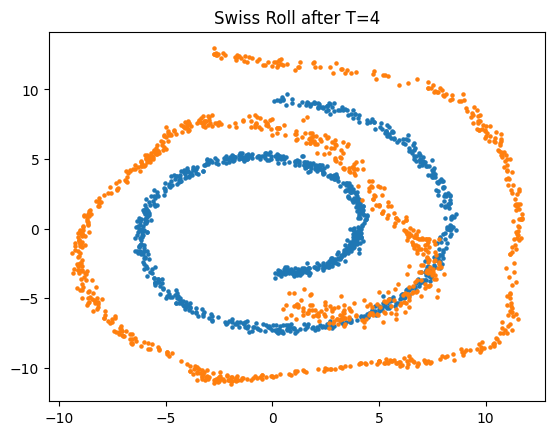

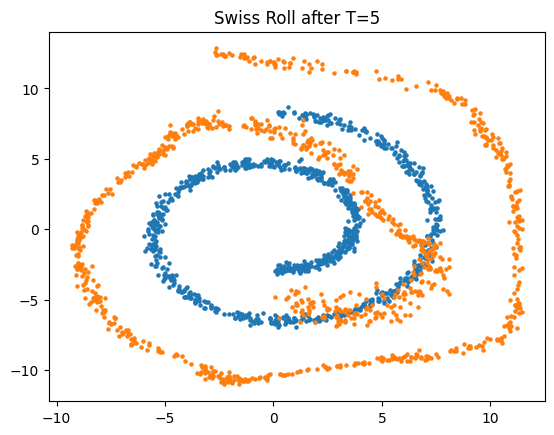

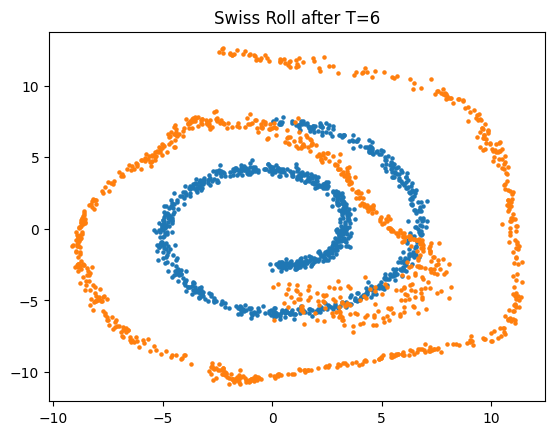

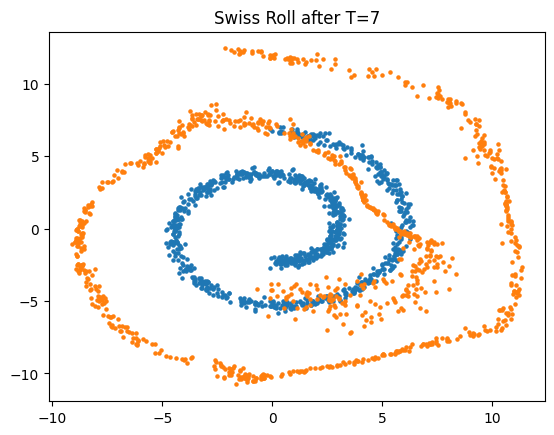

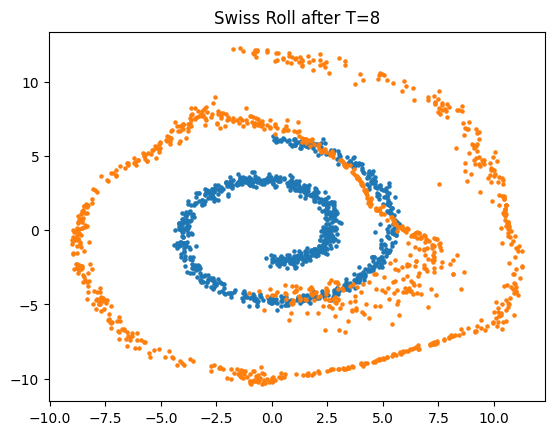

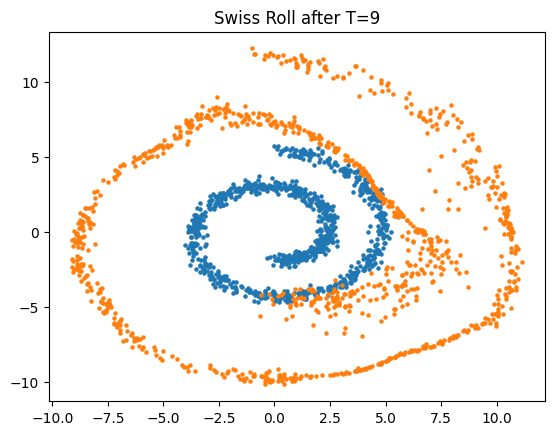

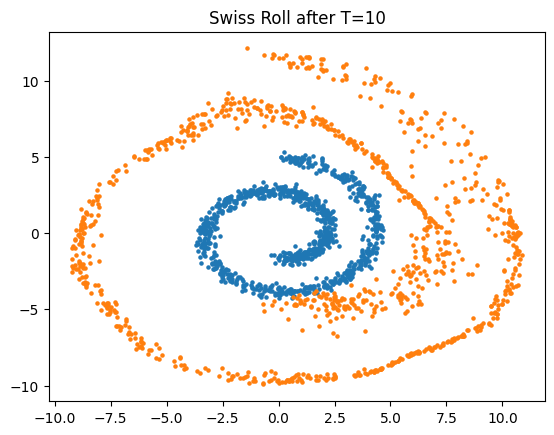

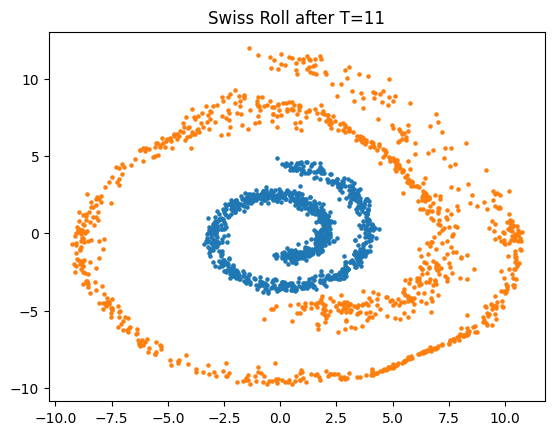

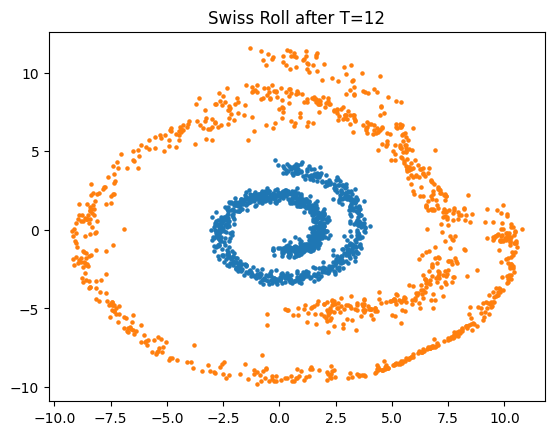

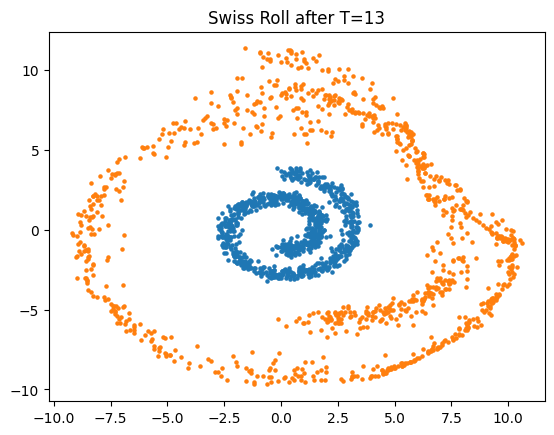

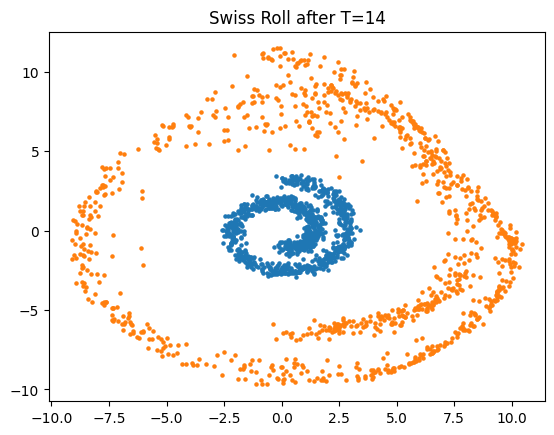

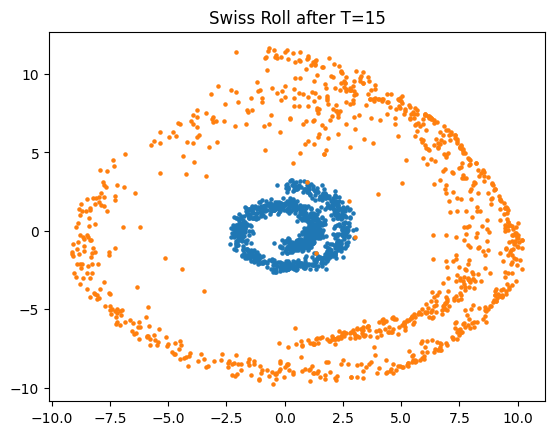

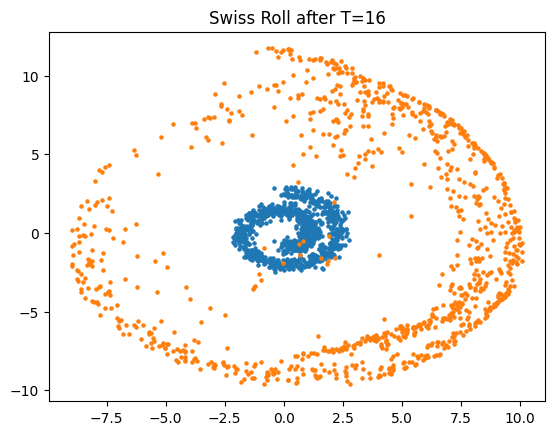

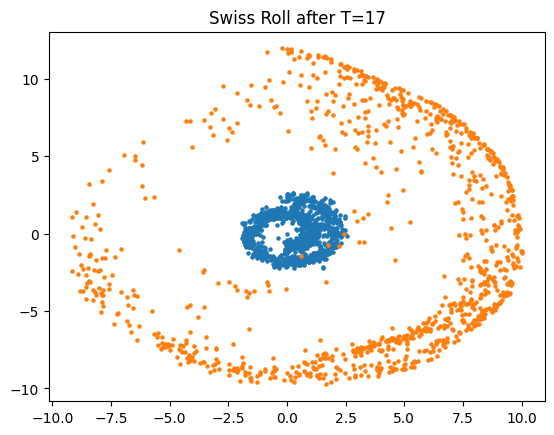

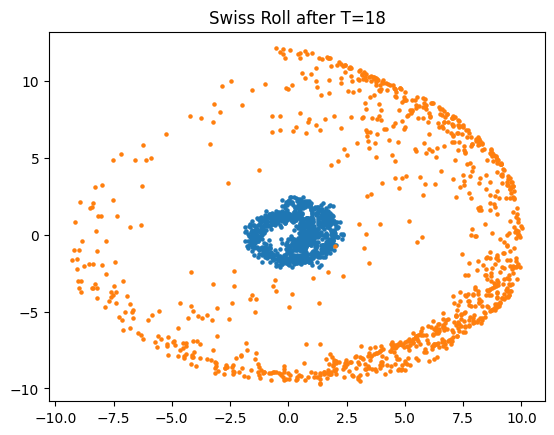

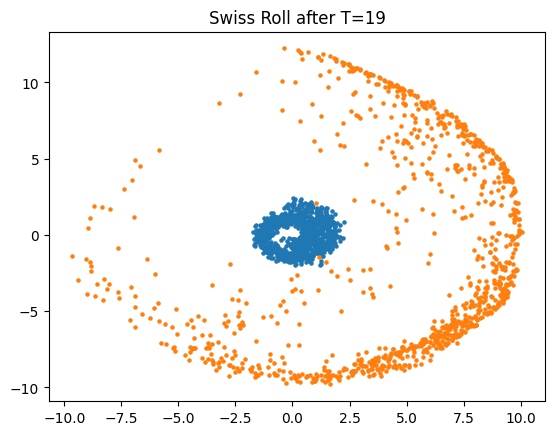

In [230]:
# prompt: Sample from the trained diffusion model

diffusion_model.model.eval()
with torch.no_grad():
  # Sample from the trained diffusion model
  num_samples = 1000
  dataset = SwissRoll(num_samples=num_samples)

  x = dataset.data
  for t in range(T):
    xt = diffusion_model.step_forward(x)
    plt.figure()
    plt.scatter(x[:, 0], x[:, 1], s=5)

    xr = xt
    for tr in range(t, -1, -1):
      xr = diffusion_model.step_reverse(xT=xt, xt=xr, t=torch.tensor(tr))
    plt.scatter(xr[:, 0], xr[:, 1], s=5)
    plt.title(f'Swiss Roll after T={t}')
    plt.show()

    x = xt


In [53]:
time_emb = nn.Embedding(10, 4)

In [57]:
t_emb = time_emb(torch.tensor(3))
t_emb

tensor([-0.1655,  1.1416,  0.0540,  2.6471], grad_fn=<EmbeddingBackward0>)

In [58]:
t_emb = t_emb.unsqueeze(0).repeat(3, 1)
t_emb

tensor([[-0.1655,  1.1416,  0.0540,  2.6471],
        [-0.1655,  1.1416,  0.0540,  2.6471],
        [-0.1655,  1.1416,  0.0540,  2.6471]], grad_fn=<RepeatBackward0>)